In [2]:
import pandas as pd
import ast
import cv2
from matplotlib import pyplot as plt
import numpy as np
import os
import keras

# import a lot of things from keras:
from keras.models import Sequential
from keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPooling2D, RandomFlip, RandomRotation, RandomContrast, RandomBrightness
from keras.metrics import categorical_crossentropy
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.utils import to_categorical

# nice progress bar for loading data
from tqdm.notebook import tqdm

# helper function for train/test split
from sklearn.model_selection import train_test_split

# import confusion matrix helper function
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# image size
IMG_SIZE = 28
SIZE = (IMG_SIZE, IMG_SIZE)

ModuleNotFoundError: No module named 'tensorflow'

# NIST Dataset

In [11]:
NIST_PATH = 'C:/Users/Marc/Desktop/ITT/08/hwr_datasets/subset'

In [ ]:
def preprocess_image(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_cropped = crop_to_content(img)
    img_resized = cv2.resize(img_cropped, SIZE)
    img_normalized = img_resized.astype('float32') / 255.0
    img_reshaped = img_normalized.reshape(1, SIZE, SIZE, 1)

    return img_reshaped


# Entfernt unnötigen weißen Rand rund um das eigentliche Zeichen
def crop_to_content(img):
    if img.ndim == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(img, 250, 255, cv2.THRESH_BINARY_INV)
    coords = cv2.findNonZero(thresh)
    x, y, w, h = cv2.boundingRect(coords)
    cropped = img[y:y+h, x:x+w]
    
    return cropped

In [ ]:
# read nist data set

subset = [ f.path for f in os.scandir(NIST_PATH) if f.is_dir() ]
subset = subset[:2] # Testweise nur ersten 2 ordner!

labels = []
images = []
for folder in subset:
    # folder name is character label but in hex -> we need to convert this for the labels
    label = bytes.fromhex(folder[-2:]).decode('ascii')
    
    print(f'reading data for label: {label}')
    for image_file in os.scandir(folder):  
        if image_file.is_file(): 
            img = cv2.imread(image_file.path)
            preprocessed_img = preprocess_image(img)
            labels.append(label)
            images.append(preprocessed_img)

# Einzigartige Labels erkennen und sortieren
label_names = sorted(list(set(labels)))
print(label_names)

# Image-Labels nummerisch kodieren

labels_numeric = [label_names.index(label) for label in labels]

In [ ]:
len(labels)

In [ ]:
len(images)

In [ ]:
example_index = 5

print(labels[example_index])
plt.imshow(images[example_index])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(images, labels_numeric, test_size=0.2, random_state=42)

print(len(X_train))
print(len(X_test))
print(len(y_train))
print(len(y_test))

y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)

train_label = y_train_one_hot
test_label = y_test_one_hot

print(X_train.shape, X_test.shape, train_label.shape, test_label.shape)

In [ ]:
# variables for hyperparameters
batch_size = 8
epochs = 50
num_classes = len(label_names)
activation = 'leaky_relu'
activation_conv = 'leaky_relu'  # LeakyReLU
layer_count = 2
num_neurons = 64

# define model structure
# with keras, we can use a model's add() function to add layers to the network one by one
model = Sequential()

# data augmentation (this can also be done beforehand - but don't augment the test dataset!)
model.add(RandomFlip('horizontal'))
model.add(RandomContrast(0.1))
#model.add(RandomBrightness(0.1))
#model.add(RandomRotation(0.2))

# first, we add some convolution layers followed by max pooling
model.add(Conv2D(64, kernel_size=(9, 9), activation=activation_conv, input_shape=(SIZE[0], SIZE[1], 1), padding='same'))
model.add(MaxPooling2D(pool_size=(4, 4), padding='same'))

model.add(Conv2D(32, (5, 5), activation=activation_conv, padding='same'))
model.add(MaxPooling2D(pool_size=(3, 3), padding='same'))

model.add(Conv2D(32, (3, 3), activation=activation_conv, padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

# dropout layers can drop part of the data during each epoch - this prevents overfitting
model.add(Dropout(0.2))

# after the convolution layers, we have to flatten the data so it can be fed into fully connected layers
model.add(Flatten())

# add some fully connected layers ("Dense")
for i in range(layer_count - 1):
    model.add(Dense(num_neurons, activation=activation))

model.add(Dense(num_neurons, activation=activation))

# for classification, the last layer has to use the softmax activation function, which gives us probabilities for each category
model.add(Dense(num_classes, activation='softmax'))

# specify loss function, optimizer and evaluation metrics
# for classification, categorial crossentropy is used as a loss function
# use the adam optimizer unless you have a good reason not to
model.compile(loss=categorical_crossentropy, optimizer="adam", metrics=['accuracy'])

# define callback functions that react to the model's behavior during training
# in this example, we reduce the learning rate once we get stuck and early stopping
# to cancel the training if there are no improvements for a certain amount of epochs
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.0001)
stop_early = EarlyStopping(monitor='val_loss', patience=3)

In [ ]:
history = model.fit(
    X_train,
    train_label,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    validation_data=(X_test, test_label),
    callbacks=[reduce_lr, stop_early]
)

In [ ]:
model.summary()

In [ ]:
model.save('text_recognition.keras')

In [ ]:
model = keras.models.load_model("text_recognition.keras")

# Vorhersagen für Testdaten erzeugen
y_pred_probs = model.predict(X_test)

# Wahrscheinlichkeits-Vektoren in Klassen-IDs umwandeln
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_true_classes = np.argmax(test_label, axis=1)

# Confusion Matrix erstellen
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Optional: Anzeigen mit Labelnamen
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
disp.plot(xticks_rotation='vertical', cmap='Blues')

print(classification_report(y_true_classes, y_pred_classes, target_names=label_names))

# IAM Dataset

In [11]:
# dataset from: https://huggingface.co/datasets/Teklia/IAM-line
df = pd.read_csv("IAM_dataset_lines.csv")

In [12]:
df

,Unnamed: 0,text,byte_image
0,0,put down a resolution on the subject,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...
1,1,and he is to be backed by Mr. Will,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...
2,2,nominating any more Labour life Peers,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...
3,3,M Ps tomorrow. Mr. Michael Foot has,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...
4,4,"Griffiths, M P for Manchester Exchange .",b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...
...,...,...,...
6477,6477,beside # Catherine . She had the stories open,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...
6478,6478,In the train going back to London I sat,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...
6479,6479,I wish I went to that school . Did you notice,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...
6480,6480,that girl who said hullo to him in the garden ?,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...


In [14]:
# decode bytes to image
def img_from_byte_str(byte_str):
    image_bytes = ast.literal_eval(byte_str)
    decoded = cv2.imdecode(np.frombuffer(image_bytes, np.uint8), -1)
    return decoded

A MOVE to stop Mr. Gaitskell from


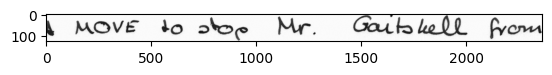

In [16]:
example_index = 6

example_label = df['text'][example_index]
example_img_data = df['byte_image'][example_index]

print(example_label)
img = img_from_byte_str(example_img_data)
plt.imshow(img, cmap="gray")